# Лабораторная работа №2

## Импорт библиотек

In [22]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline
from matplotlib import pyplot as plt

## Вспомогательные функции


In [23]:
def PLOT34(y_test, y_pred):
    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plt.scatter(y_test, y_pred, alpha=0.1)
    plt.scatter(y_test, y_test, alpha=0.1)
    plt.title('Диаграмма рассеяния вычисленных значений');
    plt.xlabel('Проверочное Y')
    plt.ylabel('Вычисленное Y')

    plt.subplot(122)
    plt.scatter(y_test, (y_test - y_pred) ** 2, alpha=0.1)
    plt.title('Диаграмма рассеяния квадрата абсолютной ошибки')
    plt.xlabel('Проверочное Y')
    plt.ylabel('Квадрат абсолютной ошибки')


def GET_METRICS_SINGLE(y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_test, y_pred)

    print("MAE : {:>9,.3f} (средняя абсолютная ошибка)".format(mae))
    print("MSE : {:>9,.6f} (среднеквадратичная ошибка)".format(mse))
    print("RMSE: {:>9,.6f} (кв. корень из среднеквадратичной ошибки)".format(rmse))
    print("R2  : {:>9,.3f} (коэфф. детерминации)".format(r2))

## Загрузка входных данных

In [24]:
df = pd.read_csv('../datasets/abalone/abalone_PREPARED.csv',  # путь к файлу, (используй автодотолнение)
                 sep=',',  # разделитель данных в файле

                 header=0,
                 )

df[:2]  # отобразить первые строки таблицы df

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_is_F,sex_is_I,sex_is_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15.0,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7.0,0,0,1


## Выбор целевой переменной и независимых признаков

In [25]:
features = ['shell_weight', 'diameter', 'sex_is_M', 'viscera_weight']
target = ['rings']

In [44]:
df[features[0]] *= 1000 
df[features[1]] /= 100
df[features[3]] *= 100000000

In [45]:
dfX = df[features]
dfY = df[target]


## Стандартизация

In [46]:
from sklearn.preprocessing import StandardScaler

scalerStdX = StandardScaler()
scalerStdY = StandardScaler()

scalerStdX.fit(dfX)
scalerStdY.fit(dfY)

print(" {:>3} {:<25} {:>16} {:>16}".format(
    "№", "Признак", "Среднее", "Ср.кв.откл."
))

for icol in range(0, len(dfX.columns)):
    print(" {:>3} {:<25} {:>16.3f} {:>16.3f}".format(
        icol,
        dfX.columns[icol],
        scalerStdX.mean_[icol],
        np.sqrt(scalerStdX.var_[icol]),
    ))

scalerStdX.transform(dfX)

dfXStd = pd.DataFrame(
    data=scalerStdX.transform(dfX),
    columns=dfX.columns,
    index=dfX.index
)

dfYStd = pd.DataFrame(
    data=scalerStdY.transform(dfY),
    columns=dfY.columns,
    index=dfY.index
)
print(" {:>3} {:<25} {:>16.3f} {:>16.3f}".format(
    "4",
    "rings",
    scalerStdY.mean_[0],
    np.sqrt(scalerStdX.var_[0])))

   № Признак                            Среднее      Ср.кв.откл.
   0 shell_weight                    228432.865       125041.636
   1 diameter                             0.004            0.001
   2 sex_is_M                             0.362            0.481
   3 viscera_weight                17518180.614     10240955.269
   4 rings                                9.521       125041.636


## Информация о целевой переменной

In [47]:
print("Среднее значение:", dfY.mean())
print("Дисперсия:", dfY.var())
print("Ср. кв. откл.:", dfY.std())

Среднее значение: rings    9.520657
dtype: float64
Дисперсия: rings    6.039308
dtype: float64
Ср. кв. откл.: rings    2.4575
dtype: float64


## Гистограммы распределения исходных и стандартизированных значений для целевого признака

(array([426., 567., 625., 592., 626., 453., 257., 160.,  50.,  20.]),
 array([-1.74688105, -1.25904355, -0.77120604, -0.28336854,  0.20446897,
         0.69230648,  1.18014398,  1.66798149,  2.15581899,  2.6436565 ,
         3.13149401]),
 <BarContainer object of 10 artists>)

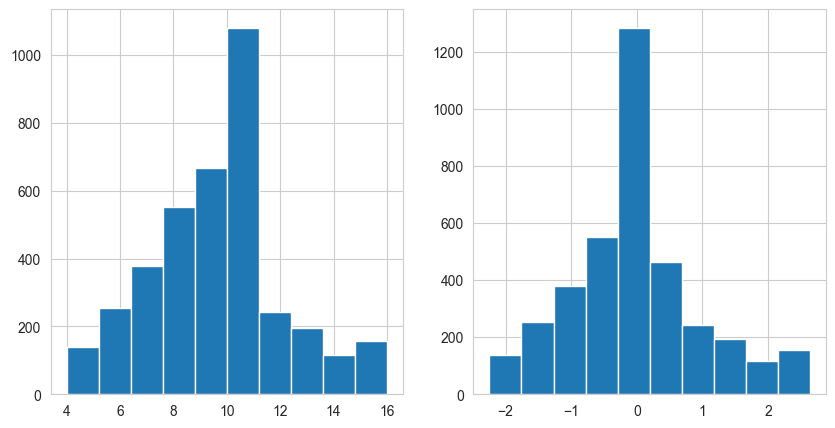

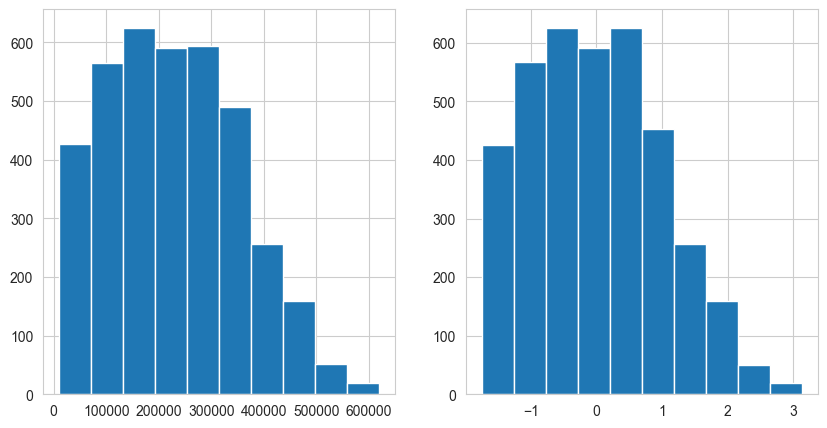

In [48]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(dfY["rings"])

plt.subplot(122)
plt.hist(dfYStd["rings"])

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(dfX["shell_weight"])

plt.subplot(122)
plt.hist(dfXStd["shell_weight"])

In [49]:
print("Среднее значение после нормализации:", dfYStd.mean())
print("Дисперсия после нормализации:", dfYStd.var())
print("Ср. кв. откл.:", dfYStd.std())

Среднее значение после нормализации: rings   -1.618291e-16
dtype: float64
Дисперсия после нормализации: rings    1.000265
dtype: float64
Ср. кв. откл.: rings    1.000132
dtype: float64


# Формирование тренировочной и проверочной выборок (при rand_seed = 8)

In [50]:
rand_seed = 8  # начальное состояние генератора случ. чисел
valid_size = 0.3  # доля тестовой части в выборке

### Не стандартизированный набор данных

In [51]:
x_train, x_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=valid_size,
    random_state=rand_seed,
    shuffle=True
)
y_train = y_train['rings']
y_test = y_test['rings']

print("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format(
    len(x_train), len(y_train),
    len(x_test), len(x_test),
    len(x_train) + len(x_test), len(y_train) + len(x_test),
))

Кол-во элементов: 
  x_train: 2643, y_train 2643 
  x_test:  1133, y_test  1133 
  total x: 3776, total y 3776 


### Стандартизированный набор данных

In [52]:
xStd_train, xStd_test, yStd_train, yStd_test = train_test_split(
    dfXStd,
    dfYStd,
    test_size=valid_size,
    random_state=rand_seed,
    shuffle=True
)

yStd_train = yStd_train['rings']
yStd_test = yStd_test['rings']


## Исследование влияния процесса стандартизации, SGDRegressor

## Не стандартизированные данные

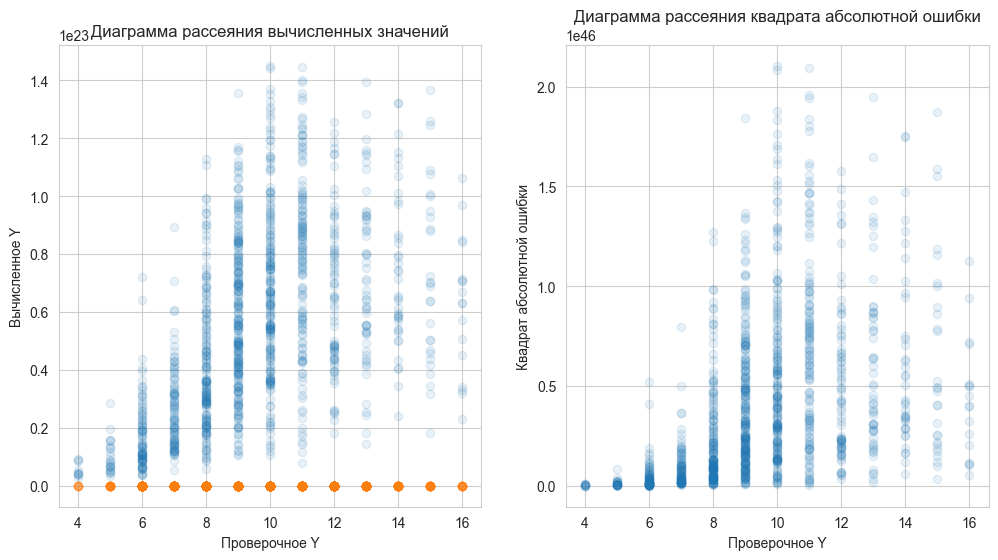

In [53]:
sgd_reg_nonStd = linear_model.SGDRegressor(
    max_iter=10000,
    tol=1e-3,
    random_state=rand_seed,
)
sgd_reg_nonStd.fit(x_train, y_train)
y_pred = sgd_reg_nonStd.predict(x_test)
PLOT34(y_test, y_pred)

In [54]:
GET_METRICS_SINGLE(y_test, y_pred)

MAE : 55,108,983,223,653,547,114,496.000 (средняя абсолютная ошибка)
MSE : 4,069,273,373,801,200,155,738,889,043,405,257,627,179,941,888.000000 (среднеквадратичная ошибка)
RMSE: 63,790,856,506,251,742,806,016.000000 (кв. корень из среднеквадратичной ошибки)
R2  : -691,137,952,871,346,474,252,438,134,447,645,384,222,179,328.000 (коэфф. детерминации)


## Стандартизированные данные

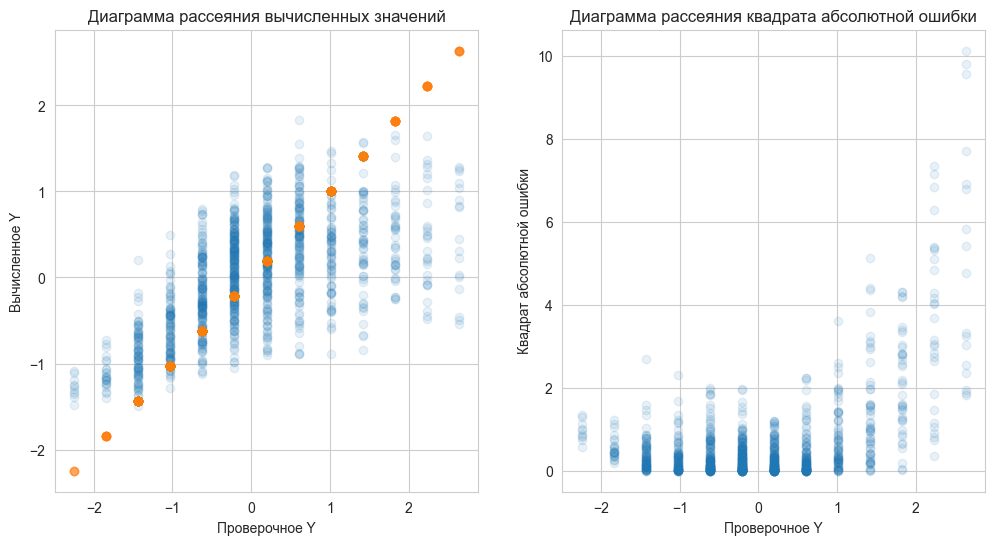

In [55]:
sgd_reg_std = linear_model.SGDRegressor(
    max_iter=10000,
    tol=2e-5,
    alpha=0.0001,
    random_state=rand_seed,
)

sgd_reg_std.fit(xStd_train, yStd_train)
y_pred_std = sgd_reg_std.predict(xStd_test)
PLOT34(yStd_test, y_pred_std)

In [38]:
GET_METRICS_SINGLE(yStd_test, y_pred_std)

MAE :     0.596 (средняя абсолютная ошибка)
MSE :  0.607032 (среднеквадратичная ошибка)
RMSE:  0.779123 (кв. корень из среднеквадратичной ошибки)
R2  :     0.378 (коэфф. детерминации)


## Повторение результатов при rand_seed=16

Не стандартизированный набор данных
MAE : 15,331,026,098,714.967 (средняя абсолютная ошибка)
MSE : 306,077,010,503,553,566,724,063,232.000000 (среднеквадратичная ошибка)
RMSE: 17,495,056,744,793.757812 (кв. корень из среднеквадратичной ошибки)
R2  : -51,161,267,932,955,468,934,152,192.000 (коэфф. детерминации)
Cтандартизированный набор данных
MAE :     0.591 (средняя абсолютная ошибка)
MSE :  0.572364 (среднеквадратичная ошибка)
RMSE:  0.756548 (кв. корень из среднеквадратичной ошибки)
R2  :     0.422 (коэфф. детерминации)


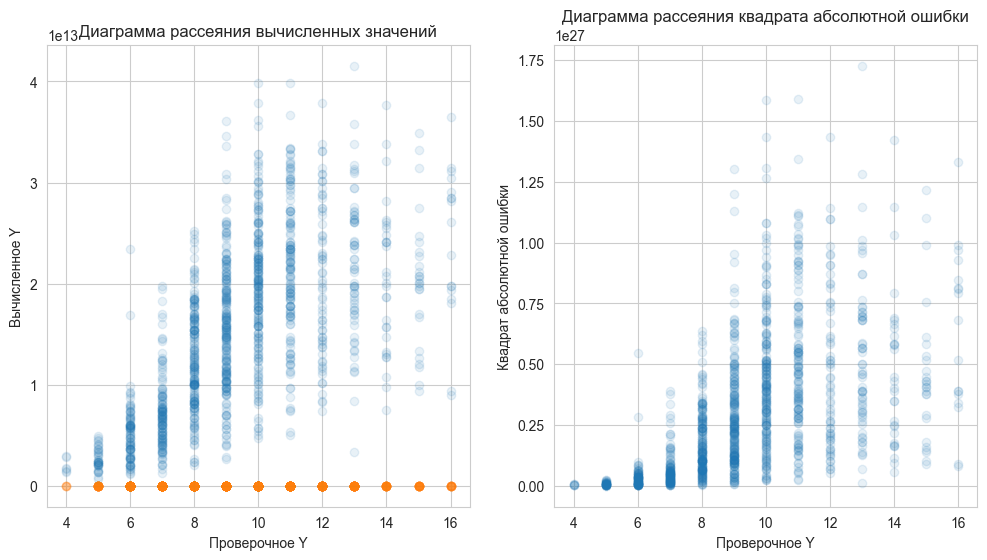

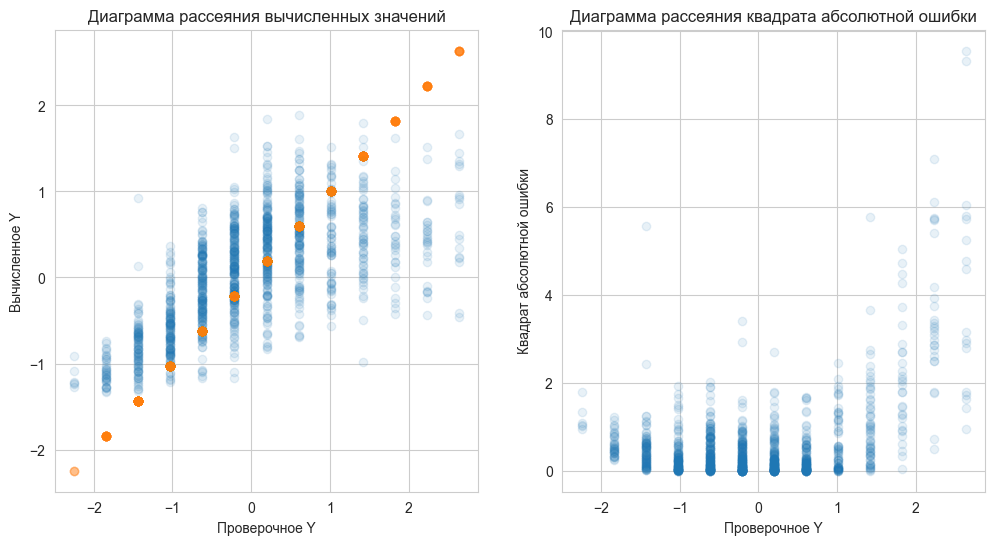

In [39]:
rand_seed = 16  # начальное состояние генератора случ. чисел
valid_size = 0.3  # доля тестовой части в выборке
### Не стандартизированный набор данных
x_train, x_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=valid_size,
    random_state=rand_seed,
    shuffle=True
)
y_train = y_train['rings']
y_test = y_test['rings']

### Стандартизированный набор данных
xStd_train, xStd_test, yStd_train, yStd_test = train_test_split(
    dfXStd,
    dfYStd,
    test_size=valid_size,
    random_state=rand_seed,
    shuffle=True
)

yStd_train = yStd_train['rings']
yStd_test = yStd_test['rings']

## Исследование влияния процесса стандартизации, SGDRegressor
## Не стандартизированные данные
sgd_reg_nonStd = linear_model.SGDRegressor(
    max_iter=10000,
    tol=1e-3,
    random_state=rand_seed,
)
sgd_reg_nonStd.fit(x_train, y_train)
y_pred = sgd_reg_nonStd.predict(x_test)
PLOT34(y_test, y_pred)
print("Не стандартизированный набор данных")
GET_METRICS_SINGLE(y_test, y_pred)
print("===========")
## Стандартизированные данные
sgd_reg_std = linear_model.SGDRegressor(
    max_iter=10000,
    tol=2e-5,
    alpha=0.0001,
    random_state=rand_seed,
)

sgd_reg_std.fit(xStd_train, yStd_train)
y_pred_std = sgd_reg_std.predict(xStd_test)
PLOT34(yStd_test, y_pred_std)
print("Cтандартизированный набор данных")
GET_METRICS_SINGLE(yStd_test, y_pred_std)
print("===========")

# Заключение по полученным результатам

- Как можем заметить по графикам, после стандартизации датасета __немного__ улучшилось поведение модели, по значению коэффициента детерминации можем сделать вывод, после стандартизации охват точек моделью увеличился. 
- Тем временем ошибка/среднеквадратичная ошибка заметно снизились после стандартизации
- При изменении начального состояния ГСЧ видим также изменения в работе модели (в лучшую сторону), а именно: вырос коэф. детерминации, и незначительно изменилось значение среднеквадратичной ошибки (RMSE)

# Кросс-валидация

In [40]:
cross_valid_model = linear_model.SGDRegressor(
    max_iter=10000,
    tol=2e-5,
    alpha=0.0001,
    random_state=rand_seed,
)

In [41]:
print("R2 Не стандартизированные  проверочные данные")
scores_cross = cross_val_score(estimator=cross_valid_model,
                               X=x_test,
                               y=y_test,
                               cv=3,
                               scoring='neg_root_mean_squared_error')

print("Значения метрики по каждому блоку cv:", scores_cross)
print("Усредненное значение метрики:", scores_cross.mean())

R2 Не стандартизированные  проверочные данные
Значения метрики по каждому блоку cv: [-5.38654768e+13 -2.73666983e+13 -2.23722169e+13]
Усредненное значение метрики: -34534797313363.324


In [56]:
print("R2 Стандартизированные проверочные данные")
scores_cross = cross_val_score(estimator=cross_valid_model,
                               X=xStd_test,
                               y=yStd_test,
                               cv=3,
                               scoring='r2')

print("Значения метрики по каждому блоку cv:", scores_cross)
print("Усредненное значение метрики:", scores_cross.mean())

R2 Стандартизированные проверочные данные
Значения метрики по каждому блоку cv: [0.33049729 0.40550446 0.39267743]
Усредненное значение метрики: 0.3762263969099811


In [43]:
from sklearn.model_selection import cross_val_predict

predicts_cross = cross_val_predict(estimator=cross_valid_model, X=x_train, y=y_train, cv=5)

print("Кросс-валидация для нестандартизированных данных: \n")
GET_METRICS_SINGLE(y_train, predicts_cross)
print("=======")

predicts_cross = cross_val_predict(estimator=cross_valid_model, X=xStd_train, y=yStd_train, cv=5)
print("Кросс-валидация для стандартизированных данных: \n")
GET_METRICS_SINGLE(yStd_train, predicts_cross)
print("=======")

Кросс-валидация для нестандартизированных данных: 

MAE : 10,823,969,801,359.951 (средняя абсолютная ошибка)
MSE : 224,898,964,289,036,154,398,834,688.000000 (среднеквадратичная ошибка)
RMSE: 14,996,631,764,800.925781 (кв. корень из среднеквадратичной ошибки)
R2  : -37,157,085,911,465,373,670,047,744.000 (коэфф. детерминации)
Кросс-валидация для стандартизированных данных: 

MAE :     0.600 (средняя абсолютная ошибка)
MSE :  0.607597 (среднеквадратичная ошибка)
RMSE:  0.779485 (кв. корень из среднеквадратичной ошибки)
R2  :     0.394 (коэфф. детерминации)


## Заключение о величине коридора изменений оценки моделей

Построение моделей методом кросс-валидации дало даже меньшие результаты по сравнению с обычной моделью (по метрикам R2 и RMSE)

# Итоговые, сводные результаты и выводы.

- Стандартизация заметно улучшила работу модели, повысив коэфф детерминации, однако не повлияла на итоговый результат из-за хорошего качества исходного датасета
- Изменение разбиения как и кросс-валидация не сильно улучшила значения в модели, из чего можем сделать вывод о равномерности исходных данных